In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Splitting Heuristics

First we want to get a general impression of how the BVH will behave when performing ray intersection querries depending on which heuristic was used to construct it. To this end spheres with an equal radius R, are placed uniformly in a unit kube centered around (0, 0, -1). The radius is chosen so that the average volume filled with spheres remains constant, this is done to prevent spheres from overlapping too much.

Since the scene is uniform, I expect that all heuristics will be quite close to eachother, with the SAH leading slightly because it has a superior stopping criteria based on a cost metric. Object median split's and space median split's stopping criteria depends only on the amount of objects left or the inability to partition the remaining objects.

In an ideal case where no bounding boxes overlap and the BVH is a full tree the amount of intersection tests can be calculated as nb_pixels * 2 * log2(N), the 2 comes from the fact that at each level 2 bounbing boxes have to be tested.

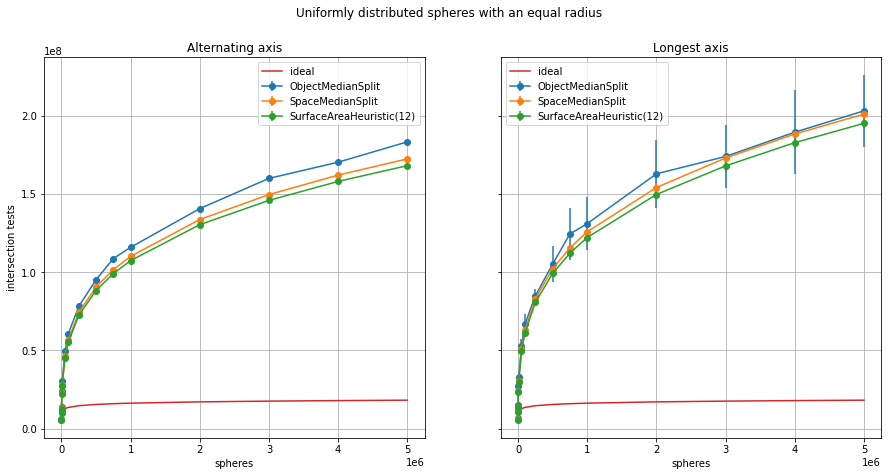

In [42]:
with open("results/splitting_heuristics_equal_spheres_uniform_position.json") as f:
    data = json.load(f)
    
    nb_spheres = np.array(data['nb_objects'])
    
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
    fig.suptitle("Uniformly distributed spheres with an equal radius")

        
    for (splitting_heuristic, intersection_tests) in sorted(data['results'].items()):        
        results = [np.array(k) for k in intersection_tests]
        averages = np.array([np.average(res) for res in results])
        stds = np.array([np.std(res) for res in results])
        
        if "Alternate" in splitting_heuristic:
            axs[0].errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic.split(" ")[1])
        else:
            axs[1].errorbar(nb_spheres, averages, yerr=stds, fmt='-o', label=splitting_heuristic.split(" ")[1])
       
    axs[0].set(ylabel="intersection tests", title="Alternating axis")
    axs[1].set(title="Longest axis")
    
    for ax in axs:    
        ideal = 640 * 640 * 2 * np.log2(nb_spheres)
        ax.plot(nb_spheres, ideal, label="ideal")
        
        ax.grid(True)
        ax.set_yscale("linear")
        ax.set_xscale("linear")
        ax.set(xlabel="spheres")
        ax.legend()
        
#     plt.savefig('results/plots/compare_splitting_heuristics2.png')

The graph does show indeed that all splitting heuristics constructs BVHs that are quite similar to eachother in terms of the amount of intersection tests needed to render the scene, with the SAH slightly better. Another thing worth noting that was quite unexpected is that the standard deviation of object median split is so high.

This graph also shows that on average the required intersection tests is still an order of magnitude greate than what would be expected in an ideal scenario, this can be explained by the fact that in this experiment bounding boxes will overlap.

# Object instancing

## Rendering performance

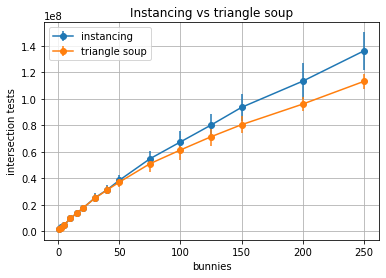

In [44]:
with open("results/instanced_intersections.json") as f1, open("results/flattened_intersections.json") as f2:
    instanced_data = json.load(f1)
    flattened_data = json.load(f2)
    
    nb_objects = np.array(instanced_data["nb_objects"])
    
    fig, ax = plt.subplots()
        
    results = [np.array(k) for k in instanced_data["results"]["Alternate, SurfaceAreaHeuristic(12)"]]
    averages = np.array([np.average(res) for res in results])
    stds = np.array([np.std(res) for res in results])
    ax.errorbar(nb_objects, averages, yerr=stds, fmt="-o", label="instancing")
    
    results = [np.array(k) for k in flattened_data["results"]["Alternate, SurfaceAreaHeuristic(12)"]]
    averages = np.array([np.average(res) for res in results])
    stds = np.array([np.std(res) for res in results])
    ax.errorbar(nb_objects, averages, yerr=stds, fmt="-o", label="triangle soup")
        
    ax.set_yscale("linear")
    ax.set_xscale("linear")
    ax.set(xlabel="bunnies", ylabel="intersection tests",title='Instancing vs triangle soup')
    ax.grid(True)
    ax.legend()
#     plt.savefig('results/plots/compare_splitting_heuristics2.png')

As we can see from the graph a triangle soup requires slightly less intersection tests when rendering the image. An experiment with significantly more bunnies is required to verify if this gap continues to widen. While performing the experiments for this part I noticed that the time it took to construct the BVH increased significantly, up to the point that it seemed to take longer than the actual rendering. This could be a subject for further testing if I had more time available.

## Memory

This experiment uses [jemalloc](http://jemalloc.net) to heap memory required to store the world. The amount of allocated heap memory was measured before creating the world and after the world has been created, the difference is then the amount of heap memory used by the world.

Because instancing requires very few additional data, just the tranformation matrixes and a pointer to the mesh (which is negligible in comparison to the mesh), I expect that the memory usage will remain relatively constant. Without instancing I expect the memory usage to increase linearly with the amount of "instances" in the scene

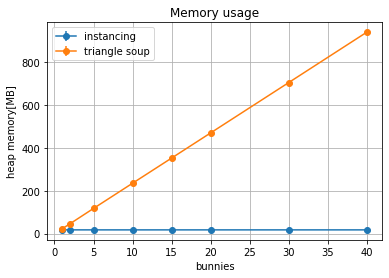

In [48]:
with open("results/instanced_memory.json") as f1, open("results/flattened_memory.json") as f2:
    instanced_data = json.load(f1)
    flattened_data = json.load(f2)
    
    nb_objects = np.array(instanced_data["nb_objects"])
    
    fig, ax = plt.subplots()
    ax.set_yscale("linear")
    ax.set_xscale("linear")
    ax.set(xlabel="bunnies", ylabel="heap memory[MB]",title='Memory usage')
        
    results = [np.array(k) for k in instanced_data["results"]["Alternate, SurfaceAreaHeuristic(12)"]]
    averages = np.array([np.average(res) for res in results]) / 1000000
    stds = np.array([np.std(res) for res in results]) / 1000000
    ax.errorbar(nb_objects, averages, yerr=stds, fmt="-o", label="instancing")
    
    results = [np.array(k) for k in flattened_data["results"]["Alternate, SurfaceAreaHeuristic(12)"]]
    averages = np.array([np.average(res) for res in results]) / 1000000
    stds = np.array([np.std(res) for res in results]) / 1000000
    ax.errorbar(nb_objects, averages, yerr=stds, fmt="-o", label="triangle soup")
        
    ax.grid(True)
    ax.legend()
#     plt.savefig('results/plots/compare_splitting_heuristics2.png')

Besides the high BVH construction times and the very high memory usage, there is another downside to not using instancing, although this one can be quite subjective. With the use of instancing you can easily compose a scene programatically from smaller components, this proved to be quite cumbersome in my implementation (this approach was used to set up the experiment), another way to resolve this issue could be to by introducing an additional translation step that flattens a scene graph. This last approach has the added drawback that almost all data structure used in the scene graph have to be cloneable (implement the Clone trait in Rust, this won't be covered further here), which again wasn't the case in my implementation as it used instancing from the start.

Because of all these benefits instancing is a sane default. For very large scenes that we want to render from multiple camera perspectives, flattening the scene graph might be beneficial if the the speedup outwheighs the increased BVH construction time.